# Supervised learning for feature selection, hyperparameter and tuning_visualization

# Overview

This project analyses supervised learning methods focusing on predictive analysis of two
Scikit-Learn health datasets: the Diabetes and the Breast Cancer datasets. The analysis
contains different supervised learning algorithms such as Logistic Regression with L1
regularization, Linear Lasso, Support Vector Machines, and k-Nearest Neighbors (k-NN).
The main objective of this project is to gain knowledge on feature choice impact on disease
progression and classification through outcome precision and hyperparameter tuning to
improve model performance.
To conclude, through a practical applications of machine learning techniques in health
analytics, the significance of relevant feature selection methods to get the best prediction has
been introduced.

Python code that creates plots of the Diabetes dataset features versus the quantitative measure of disease progression. 
Three plots that show a single feature versus the disease progression value, as follows:
A plot showing one feature that has a strong linear relationship with disease progression
A plot showing one feature that has a strong nonlinear relationship with disease progression
A plot showing one feature that has a weak relationship with disease progression

In [1]:
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

# Loading the diabetes data
diabetes = load_diabetes()                                      
X_diabetes = diabetes.data              # n samples
y_diabetes = diabetes.target            # disease progression
features = diabetes.feature_names  # name of the features

print(features)

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


Based on the printed features, three features are chosen:

1. Strong Linear relashionship: BMI (commonly associated with diabetes)
2. Strong Nonlinear relationship: BP (Blood Pressure - hypothesis that it has a nonlinear relashipnship)
3. Weak relashionship: Sex (hypothesis that this do not relate a lot)

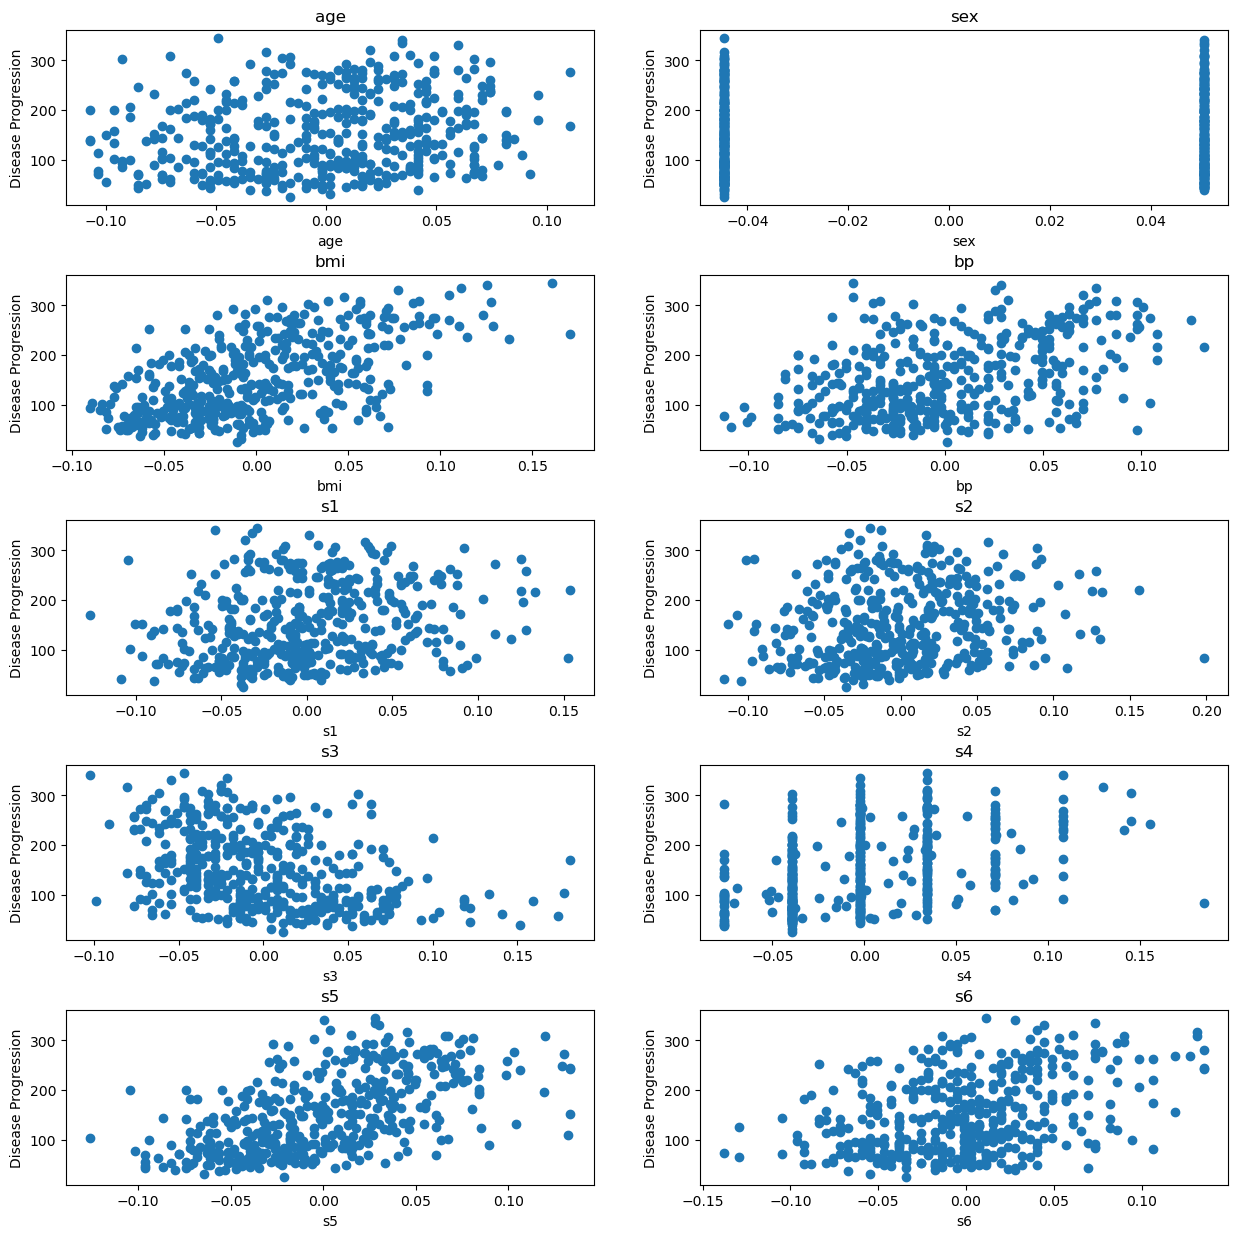

In [2]:
# Setup the figure and axes for a grid of plots
n_features = len(features)
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols  # Ensuring enough rows

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, n_rows * 3))

# Plot each feature against the disease progression (in subplots)
for i in range(n_features):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].scatter(X_diabetes[:, i], y_diabetes)
    axes[row, col].set_title(features[i])
    axes[row, col].set_xlabel(features[i])
    axes[row, col].set_ylabel('Disease Progression')
    fig.subplots_adjust(hspace=0.4)

plt.show()

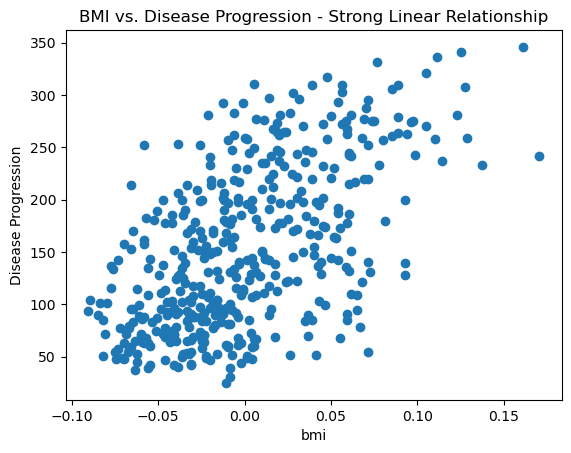

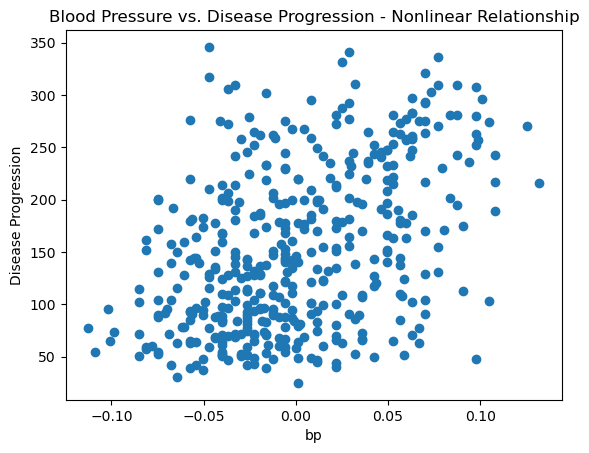

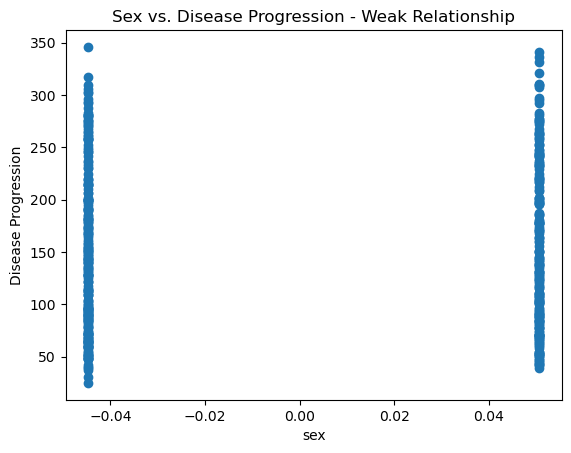

In [3]:
# Let's create a function to plot the relashionships
def plot_relationship(feature_i, title):
    plt.scatter(X_diabetes[:, feature_i], y_diabetes)   # Indexing to select feature column
    plt.title(title)
    plt.xlabel(features[feature_i])
    plt.ylabel('Disease Progression')
    plt.show()

# Plotting the relationships
plot_relationship(features.index('bmi'), 'BMI vs. Disease Progression - Strong Linear Relationship')
plot_relationship(features.index('bp'), 'Blood Pressure vs. Disease Progression - Nonlinear Relationship')
plot_relationship(features.index('sex'), 'Sex vs. Disease Progression - Weak Relationship')


Python code that splits the original dataset into three subsets: training (70%), validation (15%) and test (15%). Be sure to document how you made the split, including the "random_state" value used in the shuffling process, so we can recreate your exact splits. See "model_selection.train_test_split" for guidance.

In [4]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into 70% training, 15% validation and 15% test

# Setting 'random_state' to a number (6000) makes sure that the splits are repeatable
# X_vt and y_vt are temporary variables; vt stands for validation and test
# As only one split can be done at a time, first let's split to 70% and 30%
X_train, X_vt, y_train, y_vt = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=6000)
# Splitting the temporary set into validation and test sets (50% validation, 50% test => 15% of total each)
X_validation, X_test, y_validation, y_test = train_test_split(X_vt, y_vt, test_size=0.5, random_state=6000)

# Documenting the sizes of each dataset
print("Original size: ", X_diabetes.shape[0])
print("Training set size: ", X_train.shape[0])
print("Validation set size: ", X_validation.shape[0])
print("Test set size: ", X_test.shape[0])


Original size:  442
Training set size:  309
Validation set size:  66
Test set size:  67


Python code that uses Linear Lasso (L1 Regularization) to determine a maximum of 5 features that do the best job of predicting disease progression.

Inputs: A list of hyperparameters, and their new values, that were modified from their default values
Outputs: A list of the final features that you have chosen, along with their model coefficients or other learned parameters based on the training and validation data
Outputs: The score value of the final model applied to the test data

In [5]:
# To tune the Hyperparameters, Grid search is used (an approach seen in class lecture)

from sklearn.linear_model import Lasso

# Define a range of alpha for the grid search
# range defined in logspace, as Lasso varies logarithmically with changes in the regularization parameter
alpha_range = np.logspace(-4, -0.5, 20) 

# Initialization of parameters for Hyperparameter tuning
best_alpha = None
best_score = float('-inf')  # Equal to -infinity to make sure that when a higher score is obtained, this value is replaced
best_feature_number = 5  # Limit defined: Maximum number of features
best_model = None

# Grid search

for alpha in alpha_range:
    lasso = Lasso(alpha=alpha, max_iter=10000, random_state=6000) # hyperparameters modified
    lasso.fit(X_train, y_train)
    score = lasso.score(X_validation, y_validation) # R^2 Coefficient of determination of the prediction
    non_zero_features = np.sum(lasso.coef_ != 0)    
    # As Lasso pushes coefficients to zero, count number of coefficient that are non zero
    # np.sum 'counts' number of Trues, which are treated like 1 and False like 0, so Trues are added
    
    # Update the best model if the score is better and there are equal to or less than 5 features
    if non_zero_features <= best_feature_number and score > best_score:
        best_alpha = alpha
        best_score = score
        best_model = lasso

if best_model is not None:  # Making sure the best model was found
    # Assuming the hyperparameter have been tuned correctly: 
    # Retrain on combined training and validation set with the best alpha 
    X_tv_combined = np.concatenate((X_train, X_validation), axis=0) # vertically stacking together
    y_tv_combined = np.concatenate((y_train, y_validation))
    tuned_lasso = Lasso(alpha=best_alpha, max_iter=10000)
    tuned_lasso.fit(X_tv_combined, y_tv_combined)
    
    # Selected features and coefficients
    lasso_coefficients = tuned_lasso.coef_

    # Initializing selected features list
    selected_features = []

    #print(lasso_coefficients)
    for i in range(len(lasso_coefficients)):
        coef = lasso_coefficients[i]  # Get the coefficient value at position i
        if coef != 0:  # Check if the coefficient is non-zero
            selected_features.append(i)  # If non-zero, add the index to the selected_features list

    # Generate feature names for the selected features
    feature_names = []
    #print("Selected features", selected_features)
    for x in selected_features:
        name = features[x]  
        feature_names.append(name)  # Add the feature name to the list

    # Coefficient of the selected features
    coefficients = tuned_lasso.coef_[selected_features]
    
    # Evaluate on the test set
    test_score = tuned_lasso.score(X_test, y_test)
    
    # Output results
    print("Best Alpha: ", best_alpha)
    print("Selected Features: ", feature_names)
    print("Coefficients: ", coefficients)
    print("Test Score (R^2): ", test_score)
else:
    print("Not a good model found with <= 5 non-zero features.")

Best Alpha:  0.2069138081114788
Selected Features:  ['sex', 'bmi', 'bp', 's3', 's5']
Coefficients:  [ -86.10600564  465.94171446  241.29556777 -172.97123929  437.5433444 ]
Test Score (R^2):  0.5725294136958297


Another approach using LassoCV (since sex appears, I do not trust the previous results)

In [6]:
from sklearn.linear_model import LassoCV

# Lasso for feature selection
lasso = LassoCV(cv=10, random_state=6000, max_iter=10000).fit(X_train, y_train)
coef = lasso.coef_
important_features_lassoCV = np.argsort(np.abs(coef))[-5:]  # Selecting up to 5 features with the highest coefficients
print(coef)
# Displaying the selected features and their coefficients
print("Selected Features and Coefficients:")
for i in important_features_lassoCV:
    print(features[i],":", coef[i])

# Scoring the model on the test data
lasso_score_test = lasso.score(X_test, y_test)
print("Lasso Score on Test Data: ", lasso_score_test)


[   0.         -240.83627177  525.06442781  311.70712182 -296.72408265
   -0.           -0.          239.69515983  549.64021628   15.069636  ]
Selected Features and Coefficients:
sex : -240.83627176641195
s1 : -296.72408265124204
bp : 311.707121822507
bmi : 525.0644278055348
s5 : 549.6402162776639
Lasso Score on Test Data:  0.5857301996813286


Python code that uses any of the fundamental regression algorithms mentioned above, along with a maximum of 5 features that do the best job of predicting disease progression, based on your training data and your strategy for hyperparameter tuning based on your validation data. 
Inputs: A list of hyperparameters, and their new values, that were modified from their default values
Outputs: A list of the final features that you have chosen, along with their model coefficients or other learned parameters based on the training and validation data
Outputs: The score value of the final model applied to the test data
Observations: How well does your final model predict the targets in the test data? Provide a single example from the test data that is predicted well. Provide a single example from the test data that is predicted poorly. What could you do to improve the prediction score of your algorithm on the test data?

In [7]:
from sklearn.neighbors import KNeighborsRegressor

# In this case, there is no such thing as coefficient, thus the best 5 features are calculated based 
# on the correlations between features and the target for feature selection

correlations = np.abs(np.corrcoef(X_train.T, y_train)[0:-1, -1])
# Get indices of the best 5 features
best_5_features_index = np.argsort(correlations)[-5:]
# Extract the names  
best_5_features = np.array(features)[best_5_features_index] 

# Use only the top 5 features for training, validation, and test sets

X_train_best_5 = X_train[:, best_5_features_index]
X_validation_best_5 = X_validation[:, best_5_features_index]
X_test_best_5 = X_test[:, best_5_features_index]

# Grid search for tuning k

# Initialization
best_k = None       # best hyperparameter
best_score = float('-inf')

# Manual grid search for tuning k
for k in range(1, 30):
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train_best_5, y_train)
    score = model.score(X_validation_best_5, y_validation)
    if score > best_score:
        best_score = score
        best_k = k

# Retrain model with the best k on training + validation set
X_train_validation_top5 = np.concatenate((X_train_best_5, X_validation_best_5), axis=0)
y_train_validation = np.concatenate((y_train, y_validation))
knn_best = KNeighborsRegressor(n_neighbors=best_k)
knn_best.fit(X_train_validation_top5, y_train_validation)

# Evaluate on test data
test_score = knn_best.score(X_test_best_5, y_test)

print("Best 5 features:", best_5_features)
print("Best k value:", best_k)
print("Test score (R^2):", test_score)

Best 5 features: ['s3' 'bp' 's4' 's5' 'bmi']
Best k value: 15
Test score (mean accuracy): 0.4986396490728522


The above process should be repeated for the cancer dataset, including the three plots to illustrate features that do a good job, or a poor job of separating the classes. Shuffle and split the original dataset into training, validation and test sets. Be sure to use the "random_state" input, so we can recreate the same split when testing your code. Use the Linear Logistic Regression (with L1 regularization) algorithm to identify a maximum of 5 good features to include as inputs to the classifier. Then, develop a documented process to determine a maximum of 5 features that do the best job of classifying examples as benign or malignant using one of the fundamental classification algorithms from the previous project, e.g., logistic regression, decision tree classifier, support vector classifier, or k-Nearest Neighbors classifier.

30


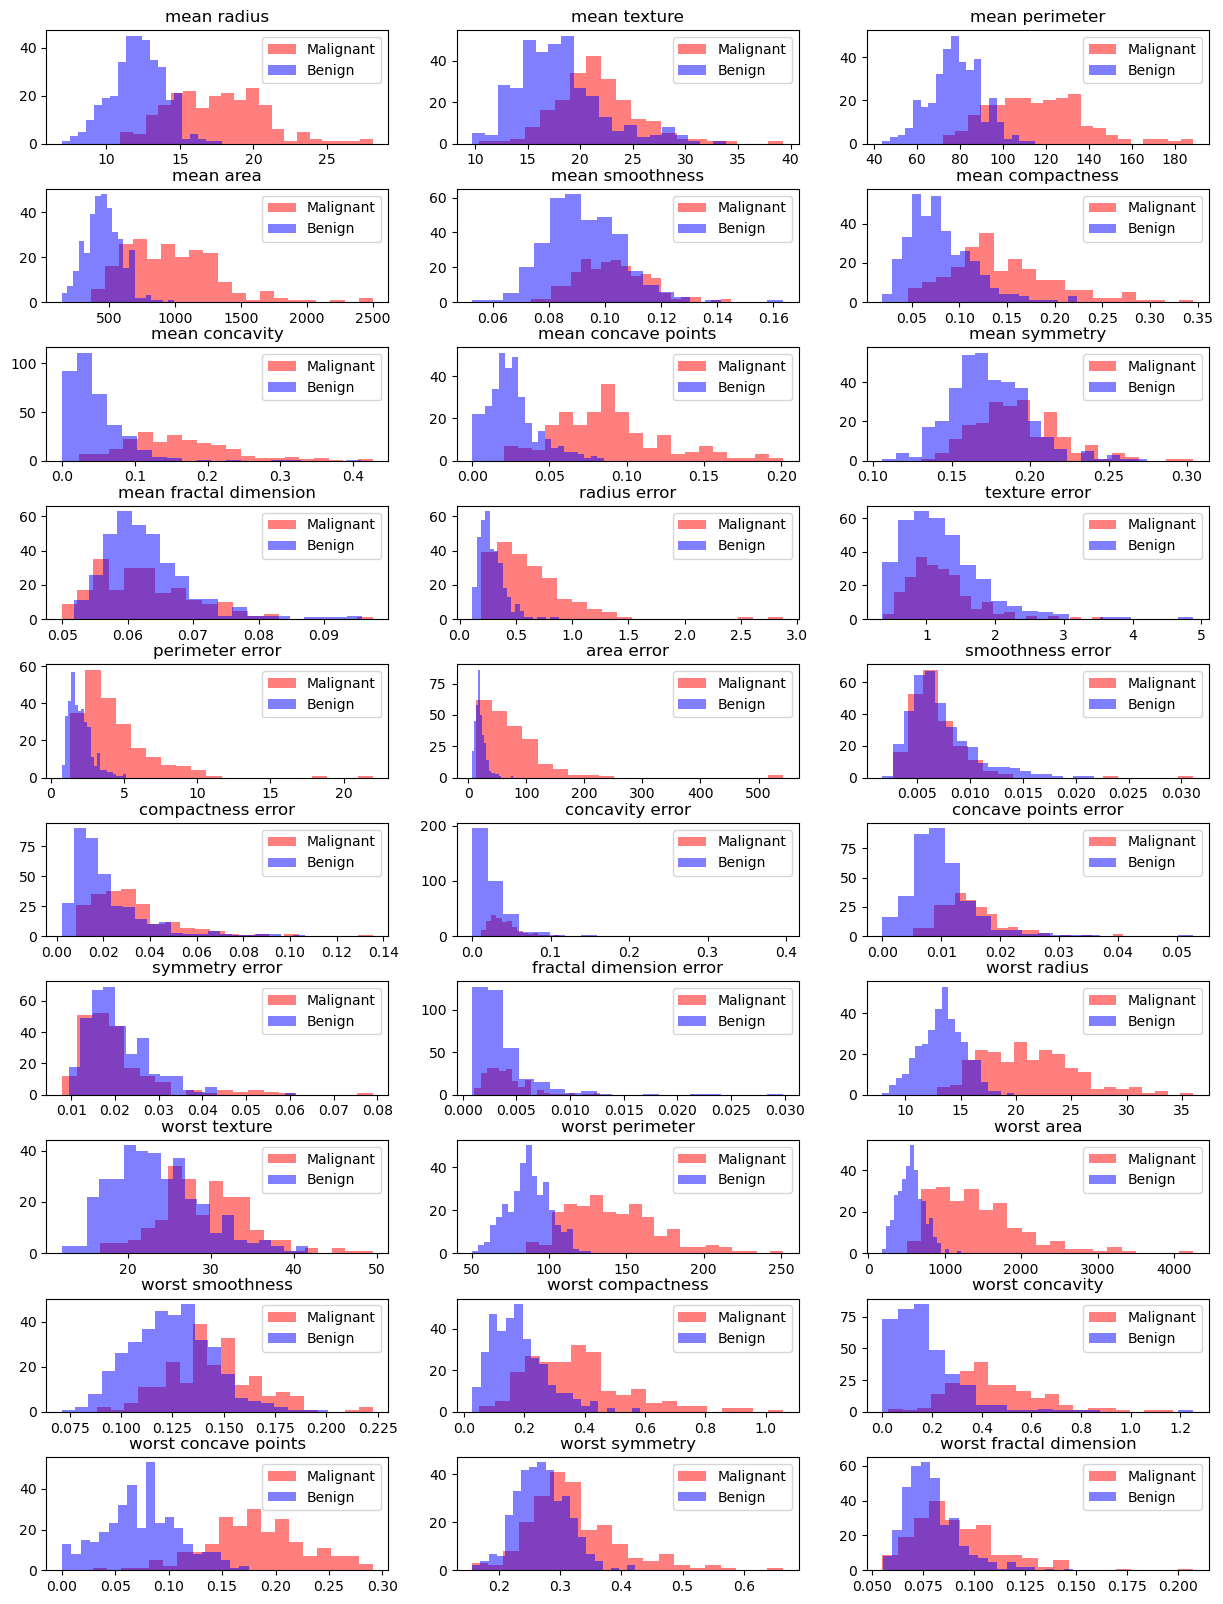

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

# Load the dataset
data = load_breast_cancer()
X_breast_cancer = data.data
y_breast_cancer = data.target
feature_names = data.feature_names
print(len(feature_names))

# Plotting all features in subplots
fig, axes = plt.subplots(10, 3, figsize=(15, 20))
fig.subplots_adjust(hspace=0.4)
axes = axes.ravel()

for i in range(len(feature_names)):
    # Separate the feature values by class
    feature_values_malignant = X_breast_cancer[y_breast_cancer == 0, i]
    feature_values_benign = X_breast_cancer[y_breast_cancer == 1, i]
    axes[i].hist(feature_values_malignant, bins=20, color='r', alpha=0.5, label='Malignant')
    axes[i].hist(feature_values_benign, bins=20, color='b', alpha=0.5, label='Benign')
    axes[i].set_title(feature_names[i])
    axes[i].legend(loc='best')

plt.show()


Based on the overlap: High overlap --> Bad featrues

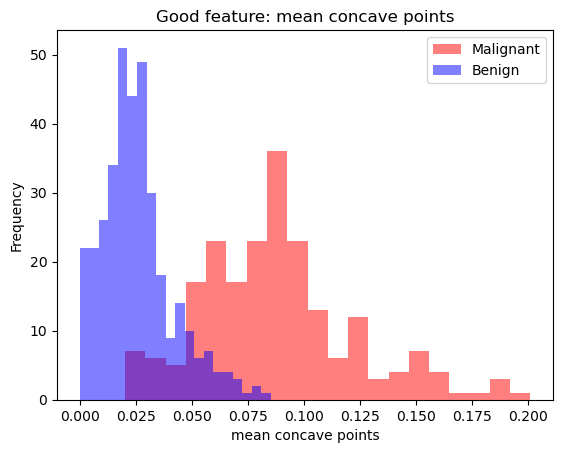

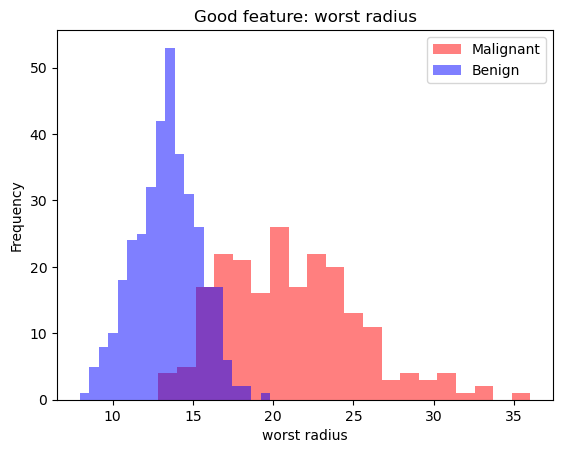

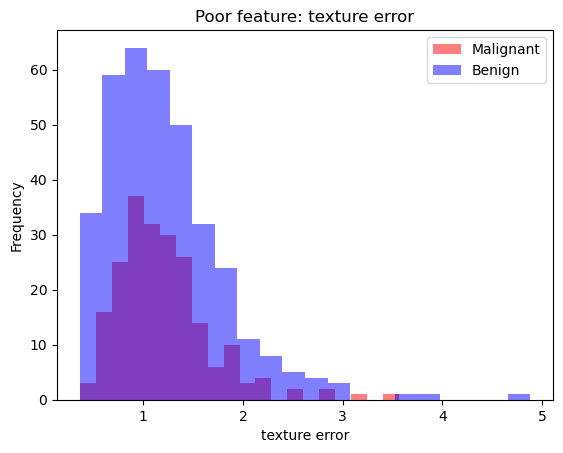

In [9]:
# Correcting the features based on your input
good1_feature = 'mean concave points'
good2_feature = 'worst radius'
poor_feature = 'texture error'

# Manually mapping feature names to indices
feature_indices = {}
index = 0
for name in feature_names:
    feature_indices[name] = index
    index += 1

# Function to plot the relationships using histograms
def plot_relationship(feature_name, title):
    feature_i = feature_indices[feature_name]  # Get the index of the feature
    # Separate the feature values by class
    feature_values_malignant = X_breast_cancer[y_breast_cancer == 0, feature_i]
    feature_values_benign = X_breast_cancer[y_breast_cancer == 1, feature_i]
    
    # Plot histograms
    plt.hist(feature_values_malignant, alpha=0.5, color = 'r', label='Malignant', bins=20)
    plt.hist(feature_values_benign, alpha=0.5, color = 'b', label='Benign', bins=20)
    plt.title(title)
    plt.xlabel(feature_name)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Plotting the relationships with histograms
plot_relationship(good1_feature, 'Good feature: ' + good1_feature)
plot_relationship(good2_feature, 'Good feature: ' + good2_feature)
plot_relationship(poor_feature, 'Poor feature: ' + poor_feature)

In [10]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into 70% training, 15% validation and 15% test

# Setting 'random_state' to a number (6000) makes sure that the splits are repeatable
# X_vt and y_vt are temporary variables; vt stands for validation and test
# As only one split can be done at a time, first let's split to 70% and 30%
X_train, X_vt, y_train, y_vt = train_test_split(X_breast_cancer, y_breast_cancer, test_size=0.3, random_state=6000)
# Splitting the temporary set into validation and test sets (50% validation, 50% test => 15% of total each)
X_validation, X_test, y_validation, y_test = train_test_split(X_vt, y_vt, test_size=0.5, random_state=6000)

# Documenting the sizes of each dataset
print("Original size: ", X_breast_cancer.shape[0])
print("Training set size: ", X_train.shape[0])
print("Validation set size: ", X_validation.shape[0])
print("Test set size: ", X_test.shape[0])


Original size:  569
Training set size:  398
Validation set size:  85
Test set size:  86


Good features identification

Linear Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression with L1 regularization
log_reg = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000, random_state=6000) # l1 penalty
log_reg.fit(X_train, y_train)

# Coefficients from the logistic regression model
coefficients = log_reg.coef_[0]  # Coefficients for the features

# Selecting features (must have coefficient that is not zero)
non_zero_indices = np.where(coefficients != 0)[0]
selected_features_indices = non_zero_indices[:5]  # Limit to max 5 features, if more than 5 are non-zero

# Extracting feature names
selected_feature_names = feature_names[selected_features_indices]

print("Selected features based on L1 regularization: ", selected_feature_names)


Selected features based on L1 regularization:  ['mean radius' 'mean texture' 'mean perimeter' 'mean area' 'texture error']


Using Decision Tree Classifier

In [12]:
from sklearn.tree import DecisionTreeClassifier

# Train the decision tree classifier
decision_tree = DecisionTreeClassifier(random_state=60000)
decision_tree.fit(X_breast_cancer, y_breast_cancer)

# Feature importances
feature_importances = decision_tree.feature_importances_

# Identify and choose top 5 features
best_features_indices = np.argsort(feature_importances)[-5:]
best_features_names = data.feature_names[best_features_indices]

print("Top 5 features selected by Decision Tree:", best_features_names)

Top 5 features selected by Decision Tree: ['compactness error' 'mean texture' 'worst texture' 'worst concave points'
 'worst radius']


# Conclusion

Throughout this project, insights about analysis and predictive modeling aspects of Diabetes
and Breast Cancer the Scikit-Learn datasets have been gained, the key points being:
1. Feature choice importance: Using L1 regularization and correlation analysis,
important features that impact disease progress and cancer classification have been
identified, understanding the selection of relevant features to make good predictions.
2. Hyperparameter tuning: Using different regression and classification methods, by
evaluating with metrics like R2 scores, the effects of hyperparameters have been
evaluated, choosing the hyperparameters that make the models perform best.
3. Visualization and Interpretation: In the first steps analyzing each dataset, the
features versus the prediction are represented, providing visual interpretation of the
importance of each feature for prediction.

The lessons learned and techniques connected in the project offer foundation to advance and
improvement within classification and final decision given a dataset.